<a href="https://colab.research.google.com/github/kini-sanjula/Blog-App/blob/dependabot%2Fpip%2Fbleach-3.3.0/Violence_Detection_on_the_AIRTLAB_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning for automatic violence detection: tests on the AIRTLab dataset


The experiments are **accuracy tests of three different deep neural networks**  based on 3D Convolutional Neural Network (3D CNN) and ConvLSTM architectures. Such models perform a classification on samples of the **AIRTLab dataset**.

The dataset is publicly available in a dedicated GitHub repository: 
> <https://github.com/airtlab/A-Dataset-for-Automatic-Violence-Detection-in-Videos>

Specifically, we tested three different models:
1. the first model uses [C3D](https://arxiv.org/abs/1412.0767) a 3D CNN pre-trained on the [Sport-1M dataset](https://cs.stanford.edu/people/karpathy/deepvideo/), as a feature extractor and an SVM a classifier. We use the C3D original weights, without retraining, therefore applying transfer learning. Only the SVM is trained from scratch on the AIRTLab dataset.
2. the second model also uses C3D until the first fully connected layer, adding two fully connected layers to obtain an end-to-end network for classification.We use the C3D original weights, without training again, therefore applying transfer learning. Only the two final fully connected layer are trained from scratch on the AIRTLab dataset.
3. the third model is based on the [ConvLSTM architecture](https://arxiv.org/abs/1506.04214), followed by two fully connected layers, getting an end-to-end network for classification. The entire network is trained from scratch on the AIRTLab dataset.



## 1 Preliminary Operations
The following cells:
- **download the C3D weights** from <https://github.com/aslucki/C3D_Sport1M_keras>
- **clone the AIRTLab** data repository into the /datarepo directory;
- define the architecture of the **C3D model**, as described by [Tran et al.](https://arxiv.org/abs/1412.0767);
- define some utility functions to **load the C3D weights**, pre-process the dataset videos to get 16-frames chunks at a resolution of 112 x 112, and extract the features with C3D.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My \Drive/violence-detection

/content/drive/My Drive/violence-detection


In [3]:
!ls

airtlabDataset	datarepo					 weights
C3D_SVM.pdf	Violence_Detection_on_the_AIRTLAB_Dataset.ipynb


In [4]:
# downloads C3D weights from https://github.com/aslucki/C3D_Sport1M_keras
!mkdir weights
!gdown --id 1rlZ-xTkTMjgWKiQFUedRnHlDgQwx6yTm -O weights/weights.h5

mkdir: cannot create directory ‘weights’: File exists
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1rlZ-xTkTMjgWKiQFUedRnHlDgQwx6yTm
To: /content/drive/My Drive/violence-detection/weights/weights.h5
100% 320M/320M [00:02<00:00, 157MB/s]


In [5]:
# downloads the AIRTLAB dataset for violence detection
!git clone https://github.com/airtlab/A-Dataset-for-Automatic-Violence-Detection-in-Videos.git datarepo

fatal: destination path 'datarepo' already exists and is not an empty directory.


In [6]:
# C3D definition
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv3D, MaxPooling3D, ZeroPadding3D

def create_C3D_model(summary = False):
    """Creates model object with the sequential API: https://keras.io/models/sequential/
        
    Parameters
    ----------
    summary : bool
              if True, prints the model summary (default False)

    Returns
    -------
    model : Sequential
            The instantiated model
    """

    model = Sequential()
    input_shape = (16, 112, 112, 3)

    model.add(Conv3D(64, (3, 3, 3), activation='relu',
                     padding='same', name='conv1',
                     input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2),
                           padding='valid', name='pool1'))
    # 2nd layer group
    model.add(Conv3D(128, (3, 3, 3), activation='relu',
                     padding='same', name='conv2'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool2'))
    # 3rd layer group
    model.add(Conv3D(256, (3, 3, 3), activation='relu',
                     padding='same', name='conv3a'))
    model.add(Conv3D(256, (3, 3, 3), activation='relu',
                     padding='same', name='conv3b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool3'))
    # 4th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv4a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv4b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool4'))
    # 5th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv5a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv5b'))
    model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool5'))
    model.add(Flatten())
    # FC layers group
    model.add(Dense(4096, activation='relu', name='fc6'))
    model.add(Dropout(.5))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(.5))
    model.add(Dense(487, activation='softmax', name='fc8'))

    if summary:
      print(model.summary())

    return model

In [7]:
# Utility functions for the experiments (chunk count, video preprocessing, feature computation, ) //feature extraction
from keras.models import model_from_json, Model
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

def getFeatureExtractor(weigthsPath, layer, verbose = False):
    """Gets the C3D feature extractor

    Parameters
    ----------
    weightsPath : str
                  Pathname of the weights file for the C3D model.
    layer : str
            Name of the output layer for the feature extractor
    verbose : bool
              if True print debug logs (default True)

    Returns
    -------

    Model : Model class
            Feature extractor

    """

    model = create_C3D_model(verbose)
    model.load_weights(weigthsPath)
    model.compile(loss='mean_squared_error', optimizer='sgd')

    return Model(inputs=model.input,outputs=model.get_layer(layer).output)

def count_chunks(videoBasePath):
    """Counts the 16 frames lenght chunks available in a dataset organized in violent and non-violent,
    cam1 and cam2 folders, placed at videoBasePath.

    Parameters
    ----------
    videoBasePath : str
                    Base path of the dataset

    Returns
    -------
    cnt : int
          number of 16 frames lenght chunks in the dataset
    """

    folders = ['violent', 'non-violent']
    cams = ['cam1', 'cam2']
    cnt = 0

    for folder in folders:
        for camName in cams:
            path = os.path.join(videoBasePath, folder, camName)

            videofiles = os.listdir(path)
            for videofile in videofiles:
                filePath = os.path.join(path, videofile)
                video = cv2.VideoCapture(filePath)
                numframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
                fps = int(video.get(cv2.CAP_PROP_FPS))
                chunks = numframes//16
                cnt += chunks
    

    return cnt

def preprocessVideos(videoBasePath, featureBasePath, verbose=True):
    """Preproccess all the videos.

    It extracts samples for the input of C3D from a video dataset, organised in violent and non-violent, cam1 and cam2 folders.
    The samples and the labels are store on two memmap numpy arrays, called samples.mmap and labels.mmap, at "featureBasePath".
    The numpy array with samples has shape (Chunk #, 16, 112, 112, 3), the labels array has shape (Chunk # 16, 112, 112, 3).
    For the AIRTLab dataset the number of chunks is 3537.

    Parameters
    ----------
    videoBasePath : str
                    Pathname to the base of the video repository, which contains two directories,
                    violent and non-violent, which are divided into cam1 and cam2.
    featureBasePath : str
                      it is the pathname of a base where the numpy arrays have to be saved.
    verbose : bool
              if True print debug logs (default True)
              
    """

    folders = ['violent', 'non-violent']
    cams = ['cam1', 'cam2']
    total_chunks = count_chunks(videoBasePath)
    npSamples = np.memmap(os.path.join(featureBasePath, 'samples.mmap'), dtype=np.float32, mode='w+', shape=(total_chunks, 16, 112, 112, 3))
    npLabels = np.memmap(os.path.join(featureBasePath, 'labels.mmap'), dtype=np.int8, mode='w+', shape=(total_chunks))
    cnt = 0

    for folder in folders:
        for camName in cams:
            path = os.path.join(videoBasePath, folder, camName)

            videofiles = os.listdir(path)
            for videofile in videofiles:
                filePath = os.path.join(path, videofile)
                video = cv2.VideoCapture(filePath)
                numframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
                fps = int(video.get(cv2.CAP_PROP_FPS))
                chunks = numframes//16
                if verbose:
                    print(filePath)
                    print("*** [Video Info] Number of frames: {} - fps: {} - chunks: {}".format(numframes, fps, chunks))
                vid = []
                videoFrames = []
                while True:
                    ret, img = video.read()
                    if not ret:
                        break
                    videoFrames.append(cv2.resize(img, (112, 112)))
                vid = np.array(videoFrames, dtype=np.float32)
                filename = os.path.splitext(videofile)[0]
                chunk_cnt = 0
                for i in range(chunks):
                    X = vid[i*16:i*16+16]
                    chunk_cnt += 1
                    npSamples[cnt] = np.array(X, dtype=np.float32)
                    if folder == 'violent':
                        npLabels[cnt] = np.int8(1)
                    else:
                        npLabels[cnt] = np.int8(0)
                    cnt += 1 

    if verbose:
        print("** Labels **")
        print(npLabels.shape)
        print('\n****\n')
        print("** Samples **")
        print(npSamples.shape)
        print('\n****\n')

    del npSamples
    del npLabels

def extractFeatures(weigthsPath, videoBasePath, featureBasePath='', verbose=True):
    """Extracts features from a video dataset, using fc6 of the C3D network.

    It extracts features from a video dataset, organized in violent and non-violent, cam1 and cam2 folders.

    Parameters
    ----------
    weightsPath : str
                  Pathname of the weights file for the C3D model.
    videoBasePath : str
                    Pathname to the base of the video repository, which contains two directories,
                    violent and non-violent, which are divided into cam1 and cam2.
    featureBasePath : str
                      if non-empty, it is the pathname of a base where numpy array has to be saved.
                      It assumes it is organized in violent, non-violent, cam1 and cam2 exactly as
                      the video repository (default '').
    verbose : bool
              if True print debug logs (default True)

    Returns
    -------
    X : numpy.ndarray
        Features array of shape (Num of video chunks, 4096) representing the 4096-dim feature vector for each video 
        chunk in the dataset
    y : numpy.ndarray
        Labels array of shape (Num of video chunks) representing the labels for all the video chunks in the dataset
        (1 = violent, 2 = non violent)
              
    """

    featureExtractor = getFeatureExtractor(weigthsPath, 'fc6', verbose)

    folders = ['violent', 'non-violent']
    cams = ['cam1', 'cam2']
    labels = []
    features = []

    for folder in folders:
        for camName in cams:
            path = os.path.join(videoBasePath, folder, camName)
            featurepath = os.path.join(featureBasePath, folder, camName)

            videofiles = os.listdir(path)
            for videofile in videofiles:
                filePath = os.path.join(path, videofile)
                video = cv2.VideoCapture(filePath)
                numframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
                fps = int(video.get(cv2.CAP_PROP_FPS))
                chunks = numframes//16
                if verbose:
                    print(filePath)
                    print("*** [Video Info] Number of frames: {} - fps: {} - chunks: {}".format(numframes, fps, chunks))
                vid = []
                videoFrames = []
                while True:
                    ret, img = video.read()
                    if not ret:
                        break
                    videoFrames.append(cv2.resize(img, (112, 112)))
                vid = np.array(videoFrames, dtype=np.float32)

                filename = os.path.splitext(videofile)[0]
                if featureBasePath:
                    featureFilePath = os.path.join(featurepath, filename + '.csv')
                    with open(featureFilePath, 'ab') as f:
                        for i in range(chunks):
                            X = vid[i*16:i*16+16]
                            out = featureExtractor.predict(np.array([X]))
                            np.savetxt(f, out)
                            out = out.reshape(4096)
                            features.append(out)
                            if folder == 'violent':
                                labels.append(1)
                            else:
                                labels.append(0)
                    
                    if verbose:
                        print('*** Saved file: ' + featureFilePath)
                        print('\n')
                else:
                    for i in range(chunks):
                        X = vid[i*16:i*16+16]
                        out = featureExtractor.predict(np.array([X]))
                        out = out.reshape(4096)
                        features.append(out)
                        if folder == 'violent':
                            labels.append(1)
                        else:
                            labels.append(0)

    y = np.array(labels)
    X = np.array(features)

    if verbose:
        print("** Labels **")
        # print(y)
        print(y.shape)
        print('\n****\n')
        print("** Features **")
        # print(X)
        print(X.shape)
        print('\n****\n')

    return X, y

def get_labels_and_features_from_files(basePath, verbose=True):
    """"Generates the feature array and the labels from saved feature files.

    It generates features and labels from saved features files, organised in violent and
    non-violent, cam1 and cam2 folders.

    Parameters
    ----------
    basePath : str
               Pathname to the base of the feature files repository, which contains two directories,
               violent and non-violent, which are divided into cam1 and cam2.
    verbose : bool
              if True print debug logs (default True)

    Returns
    -------
    X : numpy.ndarray
        Features array of shape (Num of video chunks, 4096) representing the 4096-dim feature vector for each video 
        chunk in the dataset
    y : numpy.ndarray
        Labels array of shape (Num of video chunks) representing the labels for all the video chunks in the dataset
        (1 = violent, 2 = non violent)
              
    """

    folders = ['violent', 'non-violent']
    cams = ['cam1', 'cam2']
    labels = []
    features = []

    for folder in folders:
        for camName in cams:
            path = os.path.join(basePath, folder, camName)

            textfiles = os.listdir(path)
            for textfile in textfiles:
                filePath = os.path.join(path, textfile)
                chunks = np.loadtxt(filePath)
                for chunk in chunks:
                  features.append(chunk)
                  if folder == 'violent':
                    labels.append(1)
                  else:
                    labels.append(0)

    y = np.array(labels)
    X = np.array(features)

    if verbose:
        print("** Labels **")
        # print(y)
        print(y.shape)
        print('\n****\n')
        print("** Features **")
        # print(X)
        print(X.shape)
        print('\n****\n')

    return X, y


## 2 Feature Extraction with C3D
The following cells:
- create the folders to store the feature vectors extracted from the video chunks;
- extract the features from the video of the dataset using C3D and saves them to csv files in the created folders.

In [8]:
# folders to store samples and features during the experiments
!rm -rf airtlabDataset
!mkdir airtlabDataset
!mkdir airtlabDataset/violent
!mkdir airtlabDataset/violent/cam1
!mkdir airtlabDataset/violent/cam2
!mkdir airtlabDataset/non-violent
!mkdir airtlabDataset/non-violent/cam1
!mkdir airtlabDataset/non-violent/cam2
!mkdir airtlabDataset/results

In [9]:
extractFeatures('weights/weights.h5', 'datarepo/violence-detection-dataset', 'airtlabDataset', True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 16, 112, 112, 64)  5248      
                                                                 
 pool1 (MaxPooling3D)        (None, 16, 56, 56, 64)    0         
                                                                 
 conv2 (Conv3D)              (None, 16, 56, 56, 128)   221312    
                                                                 
 pool2 (MaxPooling3D)        (None, 8, 28, 28, 128)    0         
                                                                 
 conv3a (Conv3D)             (None, 8, 28, 28, 256)    884992    
                                                                 
 conv3b (Conv3D)             (None, 8, 28, 28, 256)    1769728   
                                                                 
 pool3 (MaxPooling3D)        (None, 4, 14, 14, 256)    0

(array([[0.        , 0.        , 2.675366  , ..., 0.        , 0.        ,
         1.0464513 ],
        [0.        , 0.        , 1.3738422 , ..., 0.        , 0.        ,
         0.96310484],
        [0.        , 0.        , 2.3347216 , ..., 0.        , 0.        ,
         0.7995441 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.4574587 ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.11064535],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.1604109 ]], dtype=float32), array([1, 1, 1, ..., 0, 0, 0]))

## 3 Testing C3D + SVM
In the following cell, the tests are repeated 5 times on the extracted features of the AIRTLab dataset, using a stratified shuffle split cross-validation scheme. Specifically, **80%** of the data is used to **train** the SVM, and the remaining **20%** of the data is used for **testing** the classification accuracy. Note that, in the experiments, **only the SVM is trained** (the weights of C3D are not modified), in a **transfer learning** manner.

confusion matrix split 1
[[216  16]
 [ 17 459]]
              precision    recall  f1-score   support

 non-violent       0.93      0.93      0.93       232
     violent       0.97      0.96      0.97       476

    accuracy                           0.95       708
   macro avg       0.95      0.95      0.95       708
weighted avg       0.95      0.95      0.95       708

Accuracy: 0.9533898305084746


confusion matrix split 2
[[221  11]
 [ 15 461]]
              precision    recall  f1-score   support

 non-violent       0.94      0.94      0.94       232
     violent       0.97      0.97      0.97       476

    accuracy                           0.96       708
   macro avg       0.96      0.96      0.96       708
weighted avg       0.96      0.96      0.96       708

Accuracy: 0.963276836158192


confusion matrix split 3
[[223   9]
 [ 15 461]]
              precision    recall  f1-score   support

 non-violent       0.94      0.95      0.94       232
     violent       0.98      0.9

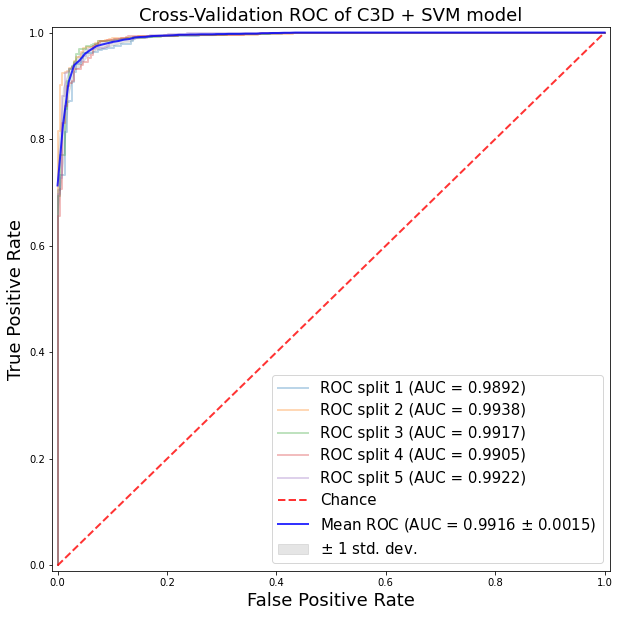

Accuracies
[0.9533898305084746, 0.963276836158192, 0.9661016949152542, 0.963276836158192, 0.9590395480225988]
Sensitivities
[0.96428571 0.96848739 0.96848739 0.98109244 0.96848739]
specificities
[0.93103448 0.95258621 0.9612069  0.92672414 0.93965517]
F1-scores
[0.96529968 0.97257384 0.97463002 0.97291667 0.96950578]
Avg accuracy: 0.9610169491525424 +/- 0.004430617836541826
Avg sensitivity: 0.9701680672268906 +/- 0.005699436960609449
Avg specificity: 0.9422413793103448 +/- 0.012959738257218013
Avg f1-score: 0.9709851990798519 +/- 0.003287942218187041


In [10]:
# Experiment 1: C3D + SVM
import pandas as pd
import numpy as np
import sklearn
from sklearn import svm
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
import matplotlib.pylab as plt

X, y = get_labels_and_features_from_files('airtlabDataset', False)
#X, y = extractFeatures('weights/weights.h5', '/datarepo/violence-detection-dataset', '', False)
  

# Cross Validation
clf = svm.SVC(kernel='linear', C = 1, probability=True)

nsplits = 5
#cv = StratifiedKFold(n_splits=nsplits, shuffle=True)
cv = StratifiedShuffleSplit(n_splits=nsplits, train_size=0.8, random_state=42)


tprs = []
aucs = []
scores = []
sens = np.zeros(shape=(nsplits))
specs = np.zeros(shape=(nsplits))
f1Scores = np.zeros(shape=(nsplits))
mean_fpr = np.linspace(0, 1, 100)
plt.figure(num=1, figsize=(10,10))
i = 1
for train, test in cv.split(X, y):
    # train = sklearn.utils.shuffle(train)
    clf.fit(X[train], y[train])
    pred_acc = clf.predict(X[test])
    split_acc = accuracy_score(y[test], pred_acc)
    scores.append(split_acc)
    prediction = clf.predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], prediction[:, 1], pos_label=1)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC split %d (AUC = %0.4f)' % (i, roc_auc))
    print('confusion matrix split ' + str(i))
    print(confusion_matrix(y[test], pred_acc))

    # y_pred = prediction.argmax(axis=-1)
    report = classification_report(y[test], pred_acc, target_names=['non-violent', 'violent'], output_dict=True)
    sens[i - 1] = report['violent']['recall']
    specs[i - 1] = report['non-violent']['recall']
    f1Scores[i - 1] = report['violent']['f1-score']
    print(classification_report(y[test], prediction.argmax(axis=-1), target_names=['non-violent', 'violent']))
    print('Accuracy: ' + str(split_acc))
    print('\n')
    i += 1
       
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of C3D + SVM model',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})

plt.savefig('C3D_SVM' + '.pdf')
plt.show()

print('Accuracies')
print(scores)
print('Sensitivities')
print(sens)
print('specificities')
print(specs)
print('F1-scores')
print(f1Scores)
print("Avg accuracy: {0} +/- {1}".format(np.mean(scores, axis=0), np.std(scores, axis=0)))
print("Avg sensitivity: {0} +/- {1}".format(np.mean(sens), np.std(sens)))
print("Avg specificity: {0} +/- {1}".format(np.mean(specs), np.std(specs)))
print("Avg f1-score: {0} +/- {1}".format(np.mean(f1Scores), np.std(f1Scores)))

## 4 Video Pre-Processing for End-to-End Networks
The following cell executes the pre-processing on all the videos, transforming them into **16-frames** samples at a resolution of **112 x 112**. The samples (and their labels) are stored into two [memmaps](https://numpy.org/doc/stable/reference/generated/numpy.memmap.html) at the "airtlabDataset" path, "**samples.mmap**" and **"labels.mmap**", to prevent the loading of **all the samples in memory** at the same time.



In [11]:
preprocessVideos('datarepo/violence-detection-dataset', 'airtlabDataset', True)

datarepo/violence-detection-dataset/violent/cam1/1.mp4
*** [Video Info] Number of frames: 145 - fps: 30 - chunks: 9
datarepo/violence-detection-dataset/violent/cam1/10.mp4
*** [Video Info] Number of frames: 186 - fps: 30 - chunks: 11
datarepo/violence-detection-dataset/violent/cam1/100.mp4
*** [Video Info] Number of frames: 103 - fps: 30 - chunks: 6
datarepo/violence-detection-dataset/violent/cam1/101.mp4
*** [Video Info] Number of frames: 182 - fps: 30 - chunks: 11
datarepo/violence-detection-dataset/violent/cam1/102.mp4
*** [Video Info] Number of frames: 106 - fps: 30 - chunks: 6
datarepo/violence-detection-dataset/violent/cam1/103.mp4
*** [Video Info] Number of frames: 143 - fps: 30 - chunks: 8
datarepo/violence-detection-dataset/violent/cam1/104.mp4
*** [Video Info] Number of frames: 239 - fps: 30 - chunks: 14
datarepo/violence-detection-dataset/violent/cam1/105.mp4
*** [Video Info] Number of frames: 96 - fps: 30 - chunks: 6
datarepo/violence-detection-dataset/violent/cam1/106.mp4


## 5 Testing End-to-End Networks
The following cells
- define **two end-to-end models** and the code to run the experiments on such models; as with C3D + SVM, the experiments are tests repeated **5 times** with the **stratified shuffle split** cross-validation scheme. In each split 80% of data are used for training, and 20% of data are used for testing. 12,5% of the training data (i.e. 10% of the entire dataset) is used for validation. In other words, in each test **70%** of data are actually for **training**, **10%** for **validation**, and **20%** for **testing**.
- run the experiment with the end-to-end model composed by **C3D and two fully connected layers**;
- run the experiment with the end-to-end model based on the **ConvLSTM** architecture (with two fully connected layers for classification);

### 5.1 C3D (until "fc6") + Fully Connected Layers

The following table shows the layers of the end to end model composed of C3D (until the first fully connected layer - fc6) and two fully-connected layers for classification. Note that, in the experiments, **only the last two dense layer are trained** (the weights of C3D are not modified), in a **transfer learning** manner.

| Layer Type                                     | Output Shape             | Parameter # |
|:-----------------------------------------------|:-------------------------|------------:|
| Conv3D, *3x3x3*, *stride=1*                    | (None, 16, 112, 112, 64) |        5248 |
| MaxPooling3D, *1x2x2*                          | (None, 16, 56, 56, 64)   |           0 |
| Conv3D, *3x3x3*, *stride=1*                    | (None, 16, 56, 56, 128)  |      221312 |
| MaxPooling3D, *2x2x2*                          | (None, 8, 28, 28, 128)   |           0 |
| Conv3D, *3x3x3*, *stride=1*                    | (None, 8, 28, 28, 256)   |      884992 |
| Conv3D, *3x3x3*, *stride=1*                    | (None, 8, 28, 28, 256)   |     1769728 |
| MaxPooling3D, *2x2x2*                          | (None, 4, 14, 14, 256)   |           0 |
| Conv3D, *3x3x3*, *stride=1*                    | (None, 4, 14, 14, 512)   |     3539456 |
| Conv3D, *3x3x3*, *stride=1*                    | (None, 4, 14, 14, 512)   |     7078400 |
| MaxPooling3D, *2x2x2*                          | (None, 2, 7, 7, 512)     |           0 |
| Conv3D, *3x3x3*, *stride=1*                    | (None, 2, 7, 7, 512)     |     7078400 |
| Conv3D, *3x3x3*, *stride=1*                    | (None, 2, 7, 7, 512)     |     7078400 |
| ZeroPadding3D                                  | (None, 2, 8, 8, 512)     |           0 |
| MaxPooling3D, *2x2x2*                          | (None, 1, 4, 4, 512)     |           0 |
| Flatten                                        | (None, 8192)             |           0 |
| Dense, *4096 units*, *ReLU activation*         | (None, 4096)             |    33558528 |
| Dropout, *0.5*                                 | (None, 4096)             |           0 |
| Dense, *512 units*, *ReLU activation*          | (None, 512)              |     2097664 |
| Dropout, *0.5*                                 | (None, 512)              |           0 |
| Dense,  *1 unit*, *Sigmoid activation*         | (None, 1)                |         513 |


### 5.2 End-to-End ConvLSTM
The following table shows the layers of the end-to-end model based on the ConvLSTM architecture. Note that **the entire network is trained**.

| Layer Type                                     | Output Shape         | Parameter # |
|:-----------------------------------------------|:---------------------|------------:|
| ConvLSTM2D, *64 3x3 filters*                   | (None, 110, 110, 64) |      154624 |
| Dropout, *0.5*                                 | (None, 110, 110, 64) |           0 |
| Flatten                                        | (None, 774400)       |           0 |
| Dense, *256 units*, *ReLU activation*          | (None, 256)          |   198246656 |
| Dropout, *0.5*                                 | (None, 256)          |           0 |
| Dense,  *1 unit*, *Sigmoid activation*         | (None, 1)            |         267 |


In [12]:
# definitions of two end-to-end models + definitions of experiments
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pylab as plt
import os
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, ConvLSTM2D


def getC3DCNNModel(verbose=True):
    """Creates the C3D + fully connected layers end-to-end model object with the
    sequential API: https://keras.io/models/sequential/

    Parameters
    ----------
    verbose : bool
              if True prints the model summary (default True)

    Returns
    -------
    model : Sequential
            The instantiated model
    """
    pretrainedModel = getFeatureExtractor('weights/weights.h5', 'fc6', False)
    for layer in pretrainedModel.layers:
        layer.trainable = False

    dropout1 = Dropout(.5)(pretrainedModel.output)
    fc7Alt = Dense(512, activation='relu', name='fc7-alt')(dropout1)
    dropout2 = Dropout(.5)(fc7Alt)
    output = Dense(1, activation='sigmoid')(dropout2)
    model = Model(inputs=pretrainedModel.inputs, outputs=output)
    if verbose:
        model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    del pretrainedModel

    return model

def getLSTMModel(verbose=True):
    """Creates the ConvLSTM + fully connected layers end-to-end model object
    with the sequential API: https://keras.io/models/sequential/

    Parameters
    ----------
    verbose : bool
              if True prints the model summary (default True)

    Returns
    -------
    model : Sequential
            The instantiated model
    """
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(3,3), input_shape=(16,112,112,3)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    if verbose:
        model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def runEndToEndExperiment(getModel, batchSize, datasetBasePath, mmapDatasetBasePath, samplesMMapName, lablesMMapName, endToEndModelName, rState):
    """"Runs the tests with end to end models.

    Parameters
    ----------
    getModel : Callable[[bool], Sequential]
               Function that instantiates the model to be tested
    batchSize : int
                Batch size to be used for training and testing
    datasetBasePath : str
                      Pathname to the base of the feature files repository,
                      which contains two directories, violent and non-violent,
                      which are divided into cam1 and cam2.
    mmapDatasetBasePath : str
                          Folder including the memory maps of samples and labels.
    samplesMMapName : str
                      Name of the file storing the numpy array of the samples,
                      with shape (Sample #, 16, 112, 112, 3). For the AIRTLab 
                      dataset the sample number is 3537.
    lablesMMapName : str
                     Name of the file storing the numpy array of the labels,
                     with shape (Sample #,). For the AIRTLab dataset the sample
                     number is 3537.
    endToEndModelName : str
                        Model name to be used in the AUC-ROC plot.
    rState : int, RandomState instance or None
             Controls the randomness of the training and testing indices produced.
             Pass an int for reproducible output across multiple function calls.
              
    """
    chunk_number = count_chunks(datasetBasePath)
    X = np.memmap(os.path.join(mmapDatasetBasePath, samplesMMapName), mode='r', dtype=np.float32, shape=(chunk_number, 16, 112, 112, 3))
    y = np.memmap(os.path.join(mmapDatasetBasePath, lablesMMapName), mode='r', dtype=np.int8, shape=(chunk_number))

    nsplits = 5
    #cv = StratifiedKFold(n_splits=nsplits, shuffle=True)
    cv = StratifiedShuffleSplit(n_splits=nsplits, train_size=0.8, random_state = rState)

    tprs = []
    aucs = []
    scores = []
    sens = np.zeros(shape=(nsplits))
    specs = np.zeros(shape=(nsplits))
    f1Scores = np.zeros(shape=(nsplits))
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(num=1, figsize=(10,10))
    i = 1

    for train, test in cv.split(X, y):

        # train = sklearn.utils.shuffle(train)

        X_train = np.memmap(os.path.join(mmapDatasetBasePath, 'samples_train.mmap'), mode='w+', dtype=np.float32, shape=X[train].shape)
        X_train[:] = X[train][:]

        X_test = np.memmap(os.path.join(mmapDatasetBasePath, 'samples_test.mmap'), mode='w+', dtype=np.float32, shape=X[test].shape)
        X_test[:] = X[test][:]

        del X

        model = getModel(i==1)

        es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights=True)
        model.fit(X_train, y[train], validation_split=0.125, epochs=50, batch_size=batchSize, verbose=1, callbacks=[es])

        del X_train

        print("Computing scores...")
        evaluation = model.evaluate(X_test, y[test])
        scores.append(evaluation)
        print("Computing probs...")
        probas = model.predict(X_test, batch_size=batchSize, verbose=1).ravel()
        del X_test

        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC split %d (AUC = %0.4f)' % (i, roc_auc))

        y_pred = np.round(probas)
        report = classification_report(y[test], y_pred, target_names=['non-violent', 'violent'], output_dict=True)
        sens[i - 1] = report['violent']['recall']
        specs[i - 1] = report['non-violent']['recall']
        f1Scores[i - 1] = report['violent']['f1-score']

        print('confusion matrix split ' + str(i))
        print(confusion_matrix(y[test], y_pred))
        print(classification_report(y[test], y_pred, target_names=['non-violent', 'violent']))
        print('Loss: ' + str(evaluation[0]))
        print('Accuracy: ' + str(evaluation[1]))
        print('\n')

        i += 1

        X = np.memmap(os.path.join(mmapDatasetBasePath, samplesMMapName), mode='r', dtype=np.float32, shape=(chunk_number, 16, 112, 112, 3))
        del report
        del model

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Cross-Validation ROC of ' + endToEndModelName  + ' model',fontsize=18)
    plt.legend(loc="lower right", prop={'size': 15})

    plt.savefig(endToEndModelName.replace('+', '') + '.pdf')
    plt.show()
  
    #print(scores)
    np_scores = np.array(scores)
    losses = np_scores[:, 0:1]
    accuracies = np_scores[:, 1:2]
    print('Losses')
    print(losses)
    print('Accuracies')
    print(accuracies)
    print('Sensitivities')
    print(sens)
    print('specificities')
    print(specs)
    print('F1-scores')
    print(f1Scores)
    print("Avg loss: {0} +/- {1}".format(np.mean(losses), np.std(losses)))
    print("Avg accuracy: {0} +/- {1}".format(np.mean(accuracies), np.std(accuracies)))
    print("Avg sensitivity: {0} +/- {1}".format(np.mean(sens), np.std(sens)))
    print("Avg specificity: {0} +/- {1}".format(np.mean(specs), np.std(specs)))
    print("Avg f1-score: {0} +/- {1}".format(np.mean(f1Scores), np.std(f1Scores)))

    del X
    del y
    del sens
    del specs
    del f1Scores
    del accuracies
    del losses
    del np_scores


In [14]:
extractFeatures('weights/weights.h5', 'datarepo/violence-detection-dataset', 'airtlabDataset', True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 16, 112, 112, 64)  5248      
                                                                 
 pool1 (MaxPooling3D)        (None, 16, 56, 56, 64)    0         
                                                                 
 conv2 (Conv3D)              (None, 16, 56, 56, 128)   221312    
                                                                 
 pool2 (MaxPooling3D)        (None, 8, 28, 28, 128)    0         
                                                                 
 conv3a (Conv3D)             (None, 8, 28, 28, 256)    884992    
                                                                 
 conv3b (Conv3D)             (None, 8, 28, 28, 256)    1769728   
                                                                 
 pool3 (MaxPooling3D)        (None, 4, 14, 14, 256)   

(array([[0.        , 0.        , 2.675366  , ..., 0.        , 0.        ,
         1.0464513 ],
        [0.        , 0.        , 1.3738422 , ..., 0.        , 0.        ,
         0.96310484],
        [0.        , 0.        , 2.3347216 , ..., 0.        , 0.        ,
         0.7995441 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.4574587 ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.11064535],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.1604109 ]], dtype=float32), array([1, 1, 1, ..., 0, 0, 0]))